In [81]:
import os
import gc
import sys
import pdb
import copy
import glob
import psutil
import imageio
import calendar
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from memory_profiler import memory_usage
from matplotlib.patches import Rectangle
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({
    'font.size'       : 15,   # Base font size
    'axes.labelsize'  : 15,   # Axis labels
    'xtick.labelsize' : 13,   # X-axis tick labels
    'ytick.labelsize' : 13,   # Y-axis tick labels
    'legend.fontsize' : 13,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()
#mpl.use('Agg')
#%matplotlib agg

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

In [82]:
importlib.reload(putil)
importlib.reload(ces)
from IPython.display import clear_output

p = 10
# ----- get data
latmin, latmax = 30, 50
tmin, tmax = date(1991,6,1), date(1993,7,2)
kwargs = {'freq':'10daily', 'return_intersection':False, 'return_members':True, 'skip_nosrctag':True, 'mass':10,
          'latmin':latmin, 'latmax':latmax, 'tmin':tmin, 'tmax':tmax, 'average_lat':True, 'average_pres':False, 'average_time':False}
u = putil.get_variable('U', **kwargs)
for dset in u.keys():
    u[dset] = u[dset].sel(plev=p, method='nearest')

# ----- get Feb-March 1992 mean
t0, t1, t2 = date(1992,2,1), date(1992,3,1), date(1992,4,1)
kwargs = {'freq':'monthly', 'return_intersection':False, 'return_members':True, 'skip_nosrctag':True, 'mass':10,
          'tmin':t0, 'tmax':t1, 'average_time':True}
uuu = putil.get_variable('U', **kwargs)
clear_output()
print('done')

clear_output()
print('done')

done


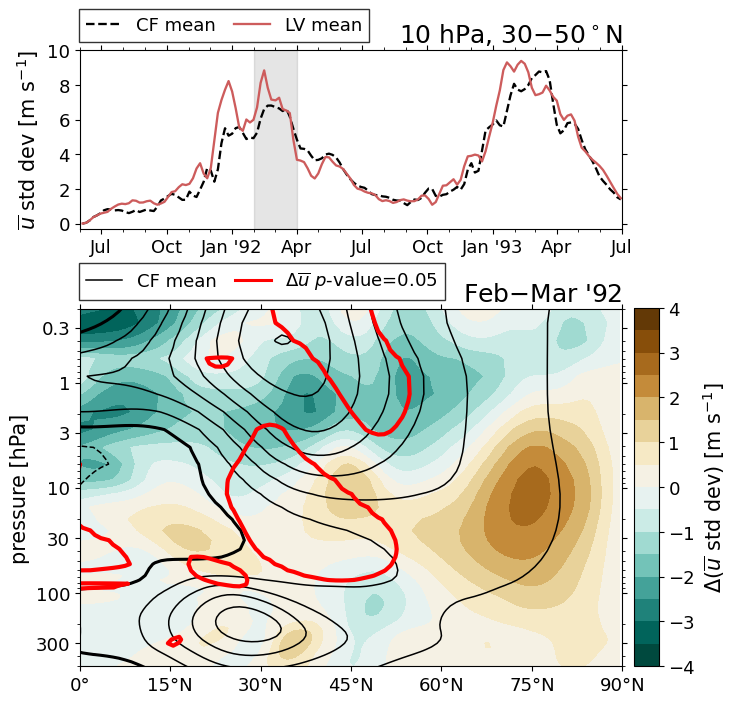

In [95]:
importlib.reload(putil)
importlib.reload(ces)

# -------- get data
# -- pinatubo
pvi      = u['ensmean']
pvi_mems = u['members']
pvi_std  = pvi_mems.std('ens')
uu = uuu['ensmean']
uu_p = uuu['pval']
uu_mems = uuu['members']
uu_std  = uu_mems.std('ens')
# -- counterfactual
cf_pvi      = u['cfmean']
cf_pvi_mems = u['cf_members']
cf_pvi_std  = cf_pvi_mems.std('ens')
uucf      = uuu['cfmean']
uucf_mems = uuu['cf_members']
uucf_std  = uucf_mems.std('ens')
# -- dims
time, lat, plev = pvi.time, uu.lat, uu.plev
time = putil.to_datetime(time)

# ----- plotting settings
topt = {'option':'solstice', 'include_year':True}
tlim = [datetime(1991,6,1),datetime(1993,7,1)]
cf_color, cf_ls = 'k', '--'
cf_std_color    = 'grey'
color, ls       = 'indianred', '-'
std_color       =  color
sig_color       = 'limegreen'

# ---- make figure
fig = plt.figure(figsize=(7,8))
gs = GridSpec(2,1,height_ratios=[0.5,1], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# ---- plot time series of std dev for CF, LV
ax1.plot(time, cf_pvi_std, color=cf_color, ls=cf_ls, lw=1.66, label='CF mean')
ax1.plot(time, pvi_std, color=color, lw=1.66, label='LV mean')
# -- format
ax1.set_xlim([tmin,tmax])
ax1.yaxis.set_ticks(np.arange(0,18,2))
ax1.set_ylim([-0.3, 10])
putil.season_timeticks(ax1, time, 'season', include_year=True, year_on_jan_only=True)
putil.format_ticks(ax1)
ax1.set_ylabel('$\\overline{u}$ std dev [m s$^{-1}$]')
# -- mark averaging window for lat-p slice in lower panel
ylim = ax1.get_ylim()
ax1.fill_between([t0,t2], y1=ylim[0], y2=ylim[1], color='k', alpha=0.1)
ax1.set_ylim(ylim)
# -- legend
ax1.legend(bbox_to_anchor=(0.55, 1.28), frameon=True, fancybox=False, edgecolor='k', ncol=2, fontsize=13, columnspacing=1)

# ---- plot std dev impact distribution in lat-p
levels=np.arange(-4,4.1,0.5)
scc = ax2.contourf(uu.lat, uu.plev, (uu_std-uucf_std).T, levels=levels, cmap='BrBG_r', norm=putil.get_cmap_norm(levels, 'twoslope'))
# -- overplot CF ensemble mean, and u-impact significance
ax2.contour(lat, plev, uucf.T, colors='k', levels=np.arange(-70,71,10), linewidths=1.1)
ax2.contour(lat, plev, uucf.T, colors='k', levels=[0], linewidths=2.2)
ax2.contour(lat, plev, uu_p.T, colors='r', levels=[0.05], linewidths=3)
# -- colorbar
cbpos = [0.917, 0.11, 0.035, 0.448] # colorbar position
cax=fig.add_axes(cbpos)
cb = plt.colorbar(scc, cax=cax, location='right', label='$\\Delta$($\\overline{u}$ std dev) [m s$^{-1}$]')
# -- format
ax2.set_ylim([0.2,500])
putil.format_paxis(ax2)
ax2.set_xlim([0,89])
putil.format_ticks(ax2)
ax2.set_ylabel('pressure [hPa]')
putil.format_lataxis(ax2, ticks=np.arange(0,91,15))
# -- legend
ax2.plot([0],[0],'k',lw=1.1,label='CF mean')
ax2.plot([0],[0],'r',lw=2.2,label='$\\Delta\\overline{u}$ $p$-value=0.05')
ax2.legend(bbox_to_anchor=(0.69, 1.155), frameon=True, fancybox=False, edgecolor='k', ncol=2, fontsize=13, columnspacing=1)

# ------ label slicing information in text boxes
tx,ty=0.02, 0.95
ax1.set_title('{} hPa, {}$-${}$^\\circ$N'.format(p, latmin, latmax), loc='right')
ax2.set_title('Feb$-$Mar \'92', loc='right')

plt.savefig('figs/vortex_winter_variability.pdf', dpi=250, bbox_inches='tight')
plt.show()